In [1]:
import numpy as np
import pandas as pd
import librosa

import matplotlib.pyplot as plt

In [2]:
import os
from pathlib import Path 

path = Path().parent
path_dir = path / "dataset"

happy_dir = path_dir / "happy"
sad_dir = path_dir / "sad"

audio_happy = os.listdir(happy_dir)
audio_sad = os.listdir(sad_dir)

In [3]:
'''
  fungsi untuk preprocessing melakukan ekstraksi fitur
  dengan root mean square agar data lebih stabil
'''
def rms(audio_path, frame=2048, hop=512):
  
    audio, sr = librosa.load(audio_path)
    rms = librosa.feature.rms(y=audio, frame_length=frame, hop_length=hop)[0]

    return rms

In [4]:
'''
  fungsi untuk preprocessing melakukan ekstraksi fitur
  dengan zero crossing rate agar data lebih stabil
'''
def zcr(audio_path, frame=2048, hop=512):
    audio, sr = librosa.load(audio_path)
    zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=frame, hop_length=hop)[0]

    return zcr

In [5]:
'''
  fungsi mfcc untuk melakukan ekstraksi fitur
  dengan mel frequency cepstral coefficients
  menggabungkan hasil preprocessing rms dan zcr
  sehingga mendapatkan matrix 1 x jumlah matrix yang diinginkan
'''
def mfcc(audio_path, frame=2048, hop=512, mfcc_num=25):
    audio, sr = librosa.load(audio_path)

    mfcc_spectrum = librosa.feature.mfcc(y=audio, sr=sr, n_fft=frame, hop_length=hop, n_mfcc=mfcc_num)

    delt1 = librosa.feature.delta(mfcc_spectrum, order=1)
    delt2 = librosa.feature.delta(mfcc_spectrum, order=2)

    mfcc_feature = np.concatenate((np.mean(mfcc_spectrum, axis=1), np.mean(delt1, axis=1), np.mean(delt2, axis=1)))

    return mfcc_feature

In [6]:
'''
  fungsi untuk melakukan ekstaksi audio
  dan optimalisasi data dengan menggabungkan
  hasil preprocessing dan mfcc
  sehingga menghasilkan matrix feature
'''
def feature_extraction(dir, audio_file, label = None, frame=2048, hop=512, mfcc_num=25):
    audio_mfcc, audio_zcr, audio_rmse, audio_label = [],[],[],[]

    for audio in audio_file:
        audio_path = dir / audio

        mfcc_score = mfcc(audio_path, frame=frame, hop=hop, mfcc_num=mfcc_num)
        zcr_score = np.mean(zcr(audio_path, frame=frame, hop=hop))
        rmse_score = np.mean(rms(audio_path, frame=frame, hop=hop))

        audio_mfcc.append(mfcc_score)
        audio_zcr.append(zcr_score)
        audio_rmse.append(rmse_score)
        audio_label.append(label)
    
    feature = np.column_stack((audio_mfcc, audio_zcr, audio_rmse))
    df = pd.DataFrame(feature)
    df.insert(loc=0, column="name", value=audio_file)
    df["label"] = audio_label

    return df


In [7]:
'''
  ekstraksi feature dari dataset happy
'''
df_happy = feature_extraction(happy_dir, audio_happy, "happy")
print(df_happy.head())

             name           0           1          2          3          4  \
0  happy-0001.wav -314.457886  129.294830 -17.988623  33.474461 -11.482511   
1  happy-0002.wav -395.502869  136.012527   2.375357  54.128048  -7.307978   
2  happy-0003.wav -366.721985  132.242188   8.187971  50.447689  -0.746726   
3  happy-0004.wav -373.125977  141.114120  -5.783168  48.331936  -8.069846   
4  happy-0005.wav -338.726593  132.259232  -8.114790  44.194748  -7.917725   

           5          6          7          8  ...        68        69  \
0  11.786289 -18.851305  11.302916 -13.167466  ...  0.008265  0.018841   
1  23.552362 -23.973137  14.294265 -10.774254  ...  0.004380 -0.015457   
2  10.303167 -12.941866   3.299066 -12.599129  ...  0.003033  0.020679   
3  11.951582 -14.797240   5.968351  -8.678323  ...  0.041998  0.034715   
4   5.655037 -16.220108   7.988503  -5.889780  ... -0.003076 -0.043340   

         70        71        72        73        74        75        76  label  
0 -0.

In [8]:
'''
  ekstraksi feature dari dataset sad
'''
df_sad = feature_extraction(sad_dir, audio_sad, "sad")
print(df_sad.head())

           name           0           1          2          3          4  \
0  sad-0001.wav -449.421448  147.722198  -9.568417  51.008976  -2.845285   
1  sad-0002.wav -394.924377  111.003624  26.793255  36.478493   1.580411   
2  sad-0003.wav -410.265503  120.917496  16.606251  58.323441 -13.436650   
3  sad-0004.wav -457.037567  144.196213  16.820171  76.620232 -15.036819   
4  sad-0005.wav -432.509460  148.646072  10.928779  63.711994  -9.459482   

           5          6          7          8  ...        68        69  \
0  30.098749 -21.938206  16.471960  -9.312575  ...  0.005756  0.006339   
1  13.909043  -0.715320   1.693681  -9.720222  ...  0.005456  0.003881   
2  26.781693 -15.498982  12.669683  -6.486483  ...  0.018226  0.021288   
3  39.247749 -21.616156  13.772663 -12.134876  ... -0.025775 -0.039017   
4  28.708157 -16.011524  10.906192  -9.422981  ... -0.012544  0.001674   

         70        71        72        73        74        75        76  label  
0  0.034731  0.00

In [9]:
'''
  menggabungkan feature dari dataset happy dan sad
  dan memberikan label untuk happy dan sad ekspresi
'''
df = pd.concat([df_happy, df_sad])
df.reset_index(drop=True, inplace=True)
df

,name,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,76,label
0,happy-0001.wav,-314.457886,129.294830,-17.988623,33.474461,-11.482511,11.786289,-18.851305,11.302916,-13.167466,...,0.008265,0.018841,-0.023740,-0.015393,0.023548,0.036065,0.042040,0.060542,0.042121,happy
1,happy-0002.wav,-395.502869,136.012527,2.375357,54.128048,-7.307978,23.552362,-23.973137,14.294265,-10.774254,...,0.004380,-0.015457,-0.016178,-0.013665,0.003776,0.026361,0.050734,0.056817,0.016707,happy
2,happy-0003.wav,-366.721985,132.242188,8.187971,50.447689,-0.746726,10.303167,-12.941866,3.299066,-12.599129,...,0.003033,0.020679,0.024065,-0.001720,0.045464,0.010982,-0.011780,0.046481,0.028754,happy
3,happy-0004.wav,-373.125977,141.114120,-5.783168,48.331936,-8.069846,11.951582,-14.797240,5.968351,-8.678323,...,0.041998,0.034715,0.068298,-0.040228,-0.019547,0.045443,0.031946,0.052498,0.022308,happy
4,happy-0005.wav,-338.726593,132.259232,-8.114790,44.194748,-7.917725,5.655037,-16.220108,7.988503,-5.889780,...,-0.003076,-0.043340,-0.007054,0.038500,0.036341,0.010976,0.031371,0.051477,0.036355,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,sad-1084.wav,-417.924408,139.764908,12.273929,52.263084,-17.304499,27.862864,-14.208331,12.585475,-16.029867,...,0.020251,-0.014291,-0.033715,0.043769,0.007429,0.019126,0.030584,0.059745,0.013470,sad
2170,sad-1085.wav,-446.779114,138.702423,27.430937,46.717842,-11.167727,24.803402,-5.096362,12.582688,-7.809765,...,-0.010041,-0.028530,0.023704,0.007363,0.020662,0.071404,0.006487,0.038625,0.009433,sad
2171,sad-1086.wav,-441.363373,139.999771,16.188068,66.505608,-11.208609,26.212502,-17.580864,12.032382,-12.642307,...,-0.032602,-0.004603,-0.023927,-0.017412,-0.072015,-0.034391,-0.013665,0.044205,0.011740,sad
2172,sad-1087.wav,-408.045013,138.958069,10.271755,55.551472,-16.234924,26.500011,-16.514378,11.222992,-13.605694,...,-0.008891,-0.013268,-0.033234,-0.020915,0.009944,0.034919,0.024074,0.069884,0.013570,sad


In [10]:
'''
  fungsi untuk melakukan label encoding
  yaitu merubah label menjadi angka
  0 untuk happy dan 1 untuk sad
  agar dapat dilakukan training model dengan baik
'''
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

encoded_y = label_encoder.fit_transform(df["label"])
label = dict(zip(label_encoder.classes_,label_encoder.transform(label_encoder.classes_)))

print("Hasil label encoding", label, sep="\n")
print("Label Encoded Target Variable", encoded_y, sep="\n")

Hasil label encoding
{'happy': 0, 'sad': 1}
Label Encoded Target Variable
[0 0 0 ... 1 1 1]


In [11]:
'''
  fungsi untuk melakukan k-fold cross validation
  dengan menggunakan model yang telah dibuat
  dan menghasilkan nilai akurasi, presisi, recall, dan f1
  hal ini dilakukan agar model yang dibuat konsisten dan tidak overfitting
'''
from sklearn.model_selection import cross_validate

def cross_validation(model, _X, _y, _cv=5):
    _scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                              X=_X,
                              y=_y,
                              cv=_cv,
                              scoring=_scoring,
                              return_train_score=True)
      
    return {"Training Accuracy scores": results['train_accuracy'],
            "Mean Training Accuracy": results['train_accuracy'].mean()*100,
            "Training Precision scores": results['train_precision'],
            "Mean Training Precision": results['train_precision'].mean(),
            "Training Recall scores": results['train_recall'],
            "Mean Training Recall": results['train_recall'].mean(),
            "Training F1 scores": results['train_f1'],
            "Mean Training F1 Score": results['train_f1'].mean(),
            "Validation Accuracy scores": results['test_accuracy'],
            "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
            "Validation Precision scores": results['test_precision'],
            "Mean Validation Precision": results['test_precision'].mean(),
            "Validation Recall scores": results['test_recall'],
            "Mean Validation Recall": results['test_recall'].mean(),
            "Validation F1 scores": results['test_f1'],
            "Mean Validation F1 Score": results['test_f1'].mean()
            }

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def train_svm(X_train, X_test, y_train, y_test, kernel="poly", C=1.0, gamma=None, dfs=None):
    svm = SVC(kernel=kernel, C=C, gamma=gamma, decision_function_shape=dfs)
    svm.fit(X_train, y_train)

    y = svm.predict(X_test)

    return accuracy_score(y_test, y)

In [13]:
from itertools import product

def svm_data(X_train, X_test, y_train, y_test):
    df = []
    gamma = [0.1, 1]
    dfs = ['ovo', 'ovr']
    kernel = ['poly', 'rbf']
    c_values = [1, 10]

    for d, x, y, g in product(dfs, c_values, kernel, gamma):
        svm = train_svm(X_train, X_test, y_train, y_test, y, x, gamma=g, dfs=d)
        df.append({
            'Kernel': y, 
            'C': x, 
            'Gamma': g, 
            'Decision Function Shape': d,
            'Accuracy (%)': svm.round(2) * 100, 
        })

    return pd.DataFrame(df)

In [14]:
'''
  pembuatan data training dan testing
  dengan menggunakan fungsi MinMaxScaler untuk melakukan normalisasi data
  dan train_test_split untuk membagi data menjadi data training dan testing
  rasio data training dan testing adalah 80:20
'''
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = df.drop(["name", "label"], axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = encoded_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
'''
  hasil data training X model yang sudah dilakukan scaling
  dengan MinMaxScaler agar data yang dihasilkan tidak terlalu besar
  dan hasil data training y model yang sudah dilakukan label encoding
'''
temp_x = pd.DataFrame(X)
temp_x

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,0.861386,0.773441,0.319268,0.401871,0.483258,0.476217,0.426332,0.636291,0.601741,0.471916,...,0.370065,0.397031,0.633576,0.298007,0.365489,0.516419,0.651215,0.691283,0.338500,0.216048
1,0.775929,0.813626,0.562723,0.649824,0.564598,0.639785,0.297822,0.712349,0.674125,0.475777,...,0.432850,0.388118,0.545738,0.313045,0.372079,0.435147,0.621170,0.713126,0.317675,0.085695
2,0.806276,0.791072,0.632214,0.605640,0.692443,0.455599,0.574603,0.432785,0.618931,0.567910,...,0.469115,0.385027,0.638285,0.393069,0.417647,0.606508,0.573555,0.556063,0.259883,0.147484
3,0.799524,0.844144,0.465186,0.580240,0.549753,0.478515,0.528050,0.500654,0.737518,0.789288,...,0.597929,0.474423,0.674231,0.481026,0.270751,0.339282,0.680249,0.665924,0.293526,0.114425
4,0.835796,0.791174,0.437311,0.530571,0.552717,0.390982,0.492350,0.552019,0.821859,0.339096,...,0.678438,0.371010,0.474328,0.331189,0.571069,0.569005,0.573536,0.664479,0.287818,0.186475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,0.752286,0.836073,0.681062,0.627434,0.369817,0.699709,0.542826,0.668902,0.515165,0.368414,...,0.416524,0.424531,0.548723,0.278173,0.591167,0.450164,0.598769,0.662502,0.334041,0.069091
2170,0.721861,0.829717,0.862266,0.560862,0.489391,0.657177,0.771450,0.668831,0.763788,0.436935,...,0.360472,0.355031,0.512256,0.392350,0.452292,0.504557,0.760629,0.601958,0.215958,0.048385
2171,0.727571,0.837478,0.727856,0.798420,0.488594,0.676766,0.458208,0.654839,0.617625,0.552971,...,0.548865,0.303269,0.573535,0.297636,0.357786,0.123612,0.433072,0.551328,0.247154,0.060216
2172,0.762704,0.831246,0.657126,0.666912,0.390657,0.680763,0.484967,0.634259,0.588486,0.742957,...,0.390709,0.357669,0.551344,0.279131,0.344423,0.460502,0.647667,0.646146,0.390730,0.069605


In [16]:
'''
  dilakukan uji score untuk memilih model yang terbaik
  model yang terbaik adalah model yang memiliki nilai akurasi paling tinggi
  dan akan digunakan untuk melakukan training model
'''
svm_score = svm_data(X_train,X_test, y_train, y_test)
svm_score = svm_score.sort_values(by=['Accuracy (%)'], ascending=False)

In [17]:
'''
  dapat dilihat pada hasil uji score bahwa 
  model dengan kernel rbf mendominasi nilai akurasi tertinggi
  disini saya menggunakan 
  kernel rbf, C=10, gamma=0.1, dfs=ovr dengan akurasi sebesar 0.86
'''
svm_score

,Kernel,C,Gamma,Decision Function Shape,Accuracy (%)
2,rbf,1,0.1,ovo,86.0
4,poly,10,0.1,ovo,86.0
6,rbf,10,0.1,ovo,86.0
7,rbf,10,1.0,ovo,86.0
10,rbf,1,0.1,ovr,86.0
12,poly,10,0.1,ovr,86.0
14,rbf,10,0.1,ovr,86.0
15,rbf,10,1.0,ovr,86.0
0,poly,1,0.1,ovo,85.0
3,rbf,1,1.0,ovo,85.0


In [18]:
'''
  memilih model yang terbaik untuk dilakukan training
'''
svm = SVC(kernel="rbf", C=10, gamma=0.1, decision_function_shape="ovr")
svm.fit(X_train, y_train)

SVC(C=10, gamma=0.1)

In [19]:
'''
  berikut adalah hasil training model yang dilakukan
  dengan pemilihan model terbaik yang sudah dilakukan sebelumnya
'''

result = cross_validation(svm, X, y, 5)
for k, v in result.items():
    if isinstance(v, np.ndarray):
        for i, val in enumerate(v):
            print(f"{k} {i+1}: {val}")
    else:
        print(k,v)
    
        print("-"*50)


Training Accuracy scores 1: 0.8976423231742381
Training Accuracy scores 2: 0.9045428407130535
Training Accuracy scores 3: 0.894767107533065
Training Accuracy scores 4: 0.8953421506612996
Training Accuracy scores 5: 0.8971264367816092
Mean Training Accuracy 89.78841717726532
--------------------------------------------------
Training Precision scores 1: 0.8827433628318584
Training Precision scores 2: 0.8911111111111111
Training Precision scores 3: 0.8736383442265795
Training Precision scores 4: 0.8837988826815643
Training Precision scores 5: 0.8895152198421646
Mean Training Precision 0.8841613841386555
--------------------------------------------------
Training Recall scores 1: 0.9172413793103448
Training Recall scores 2: 0.9218390804597701
Training Recall scores 3: 0.9228998849252014
Training Recall scores 4: 0.9102416570771001
Training Recall scores 5: 0.906896551724138
Mean Training Recall 0.9158237106993109
--------------------------------------------------
Training F1 scores 1: 0.8

In [20]:
'''
  export model yang sudah dilakukan training
  dan juga scaler yang digunakan untuk melakukan scaling data
'''

#import pickle
#pickle.dump(svm, open("svm_2000data_new_1_fix.pkl", "wb"))
#pickle.dump(scaler, open("scaler_svm_2000data_new_1.pkl", "wb"))


'\n  export model yang sudah dilakukan training\n  dan juga scaler yang digunakan untuk melakukan scaling data\n'

In [21]:
'''
  fungsi buat nampilin plot hasil perbandingan training
  dan validation dari model
'''
import matplotlib.pyplot as plt
def plot_result(x_label, y_label, plot_title, train_data, val_data):
    plt.figure(figsize=(12,6))
    labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
    X_axis = np.arange(len(labels))
    ax = plt.gca()
    plt.ylim(0.40000, 1)
    plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
    plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
    plt.title(plot_title, fontsize=30)
    plt.xticks(X_axis, labels)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

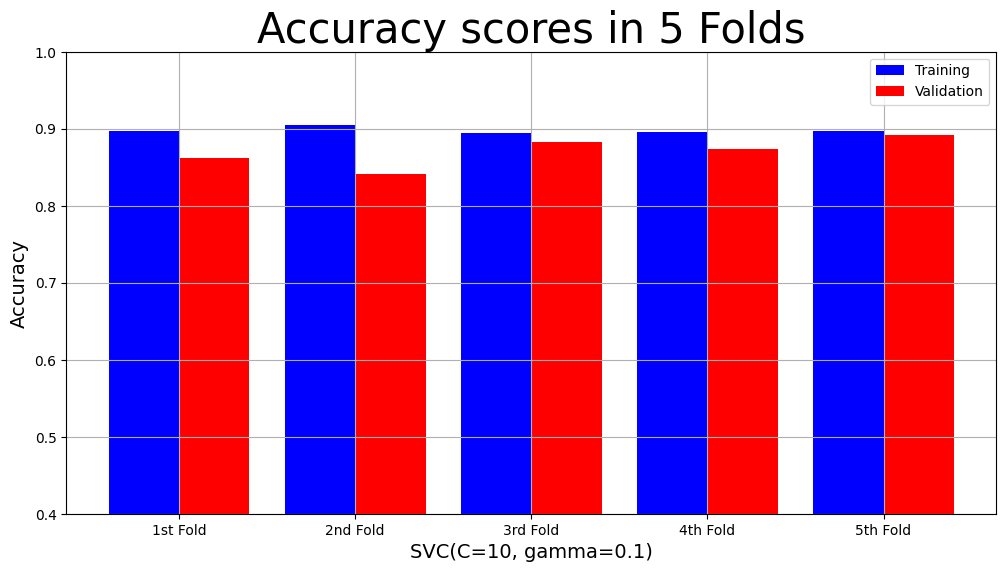

In [22]:
plot_result(svm, "Accuracy", "Accuracy scores in 5 Folds", result["Training Accuracy scores"], result["Validation Accuracy scores"])

In [23]:
'''
  fungsi untuk memprediksi data baru
  dengan menggunakan model yang sudah dilakukan training
  dan scaler yang digunakan untuk melakukan scaling data
'''
def prediction(model, df):
    temp = df
    X = temp.drop(["name", "label"], axis=1)
    X = scaler.transform(X)
    
    print(X.shape)
    y = np.array(temp['label'].apply(lambda x: 1 if x == "sad" else 0))

    y_pred = model.predict(X)
    print(y_pred)

    for i in range(len(y)):
        label = "happy" if y_pred[i] == 0 else "sad"
        print(f"Prediction {temp['name'][i]} : {label}")

In [24]:
prediction(svm, df)

(2174, 77)
[0 0 0 ... 1 1 1]
Prediction happy-0001.wav : happy
Prediction happy-0002.wav : happy
Prediction happy-0003.wav : happy
Prediction happy-0004.wav : happy
Prediction happy-0005.wav : happy
Prediction happy-0006.wav : happy
Prediction happy-0007.wav : happy
Prediction happy-0008.wav : happy
Prediction happy-0009.wav : happy
Prediction happy-0010.wav : happy
Prediction happy-0011.wav : happy
Prediction happy-0012.wav : happy
Prediction happy-0013.wav : happy
Prediction happy-0014.wav : happy
Prediction happy-0015.wav : happy
Prediction happy-0016.wav : happy
Prediction happy-0017.wav : sad
Prediction happy-0018.wav : happy
Prediction happy-0019.wav : happy
Prediction happy-0020.wav : happy
Prediction happy-0021.wav : happy
Prediction happy-0022.wav : sad
Prediction happy-0023.wav : happy
Prediction happy-0024.wav : happy
Prediction happy-0025.wav : happy
Prediction happy-0026.wav : sad
Prediction happy-0027.wav : happy
Prediction happy-0028.wav : happy
Prediction happy-0029.wav

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

pred = svm.predict(X_test)

report = classification_report(y_test, pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report = report.rename(index={'0': 'happy', '1': 'sad'})

report

,precision,recall,f1-score,support
happy,0.854460,0.854460,0.854460,213.000000
sad,0.860360,0.860360,0.860360,222.000000
accuracy,0.857471,0.857471,0.857471,0.857471
macro avg,0.857410,0.857410,0.857410,435.000000
weighted avg,0.857471,0.857471,0.857471,435.000000


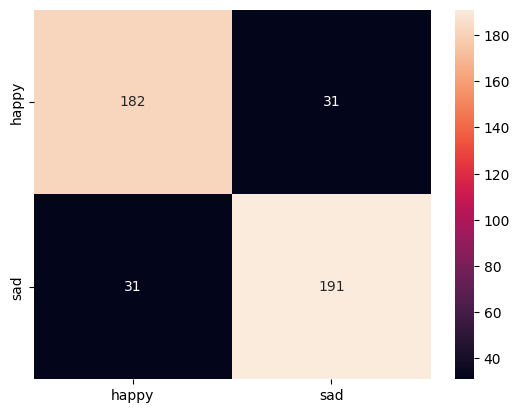

In [31]:
cfmatrix = confusion_matrix(y_test, pred)
cfmatrix = pd.DataFrame(cfmatrix, index=['happy', 'sad'], columns=['happy', 'sad'])
sns.heatmap(cfmatrix, annot=True, fmt='g')
plt.show()

#### dari hasil confusion matrix dilihat bahwa
#### 1. dari total 435 data test yang ada 
#### 2. dari sebanyak 213 data test ekspresi happy, model berhasil memprediksi 182 data dengan benar dan 31 data salah
#### 3. dari sebanyak 222 data test ekspresi sad, model berhasil memprediksi 191 data dengan benar dan 31 data salah